Google Colab note:
- Check in which folder you are in

In [1]:
import os
print(os.getcwd())

/content


Upload the data file in that folder
- It will be deleted after your session

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(print(tf.__version__))

Instructions for updating:
non-resource variables are not supported in the long term


2.11.0
None


#Read the data
- From CSV to Pandas data frame

In [3]:
iris = pd.read_csv('Iris.csv')

In [4]:
iris.shape

(150, 6)

In [5]:
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


#Features
- Column 1 : id
- Columns 2 - 5: features/attributes
- Column 6: label

We will to do a binary classification, so we will keep the first 100 rows of data

Iris-setosa species is linearly separable from the other two, but the other two are not linearly separable from each other.To keep the species blance Iris-setosa and Iris-versicolor are choosen

In [6]:
iris = iris[:100]

#Covert the string lables to numerals

In [7]:
iris.Species = iris.Species.replace(to_replace=['Iris-setosa', 'Iris-versicolor'], value=[0, 1])

<ipython-input-7-b37ba9158f8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris.Species = iris.Species.replace(to_replace=['Iris-setosa', 'Iris-versicolor'], value=[0, 1])


#Visualize two class examples in 2D space
- We simply select first two features

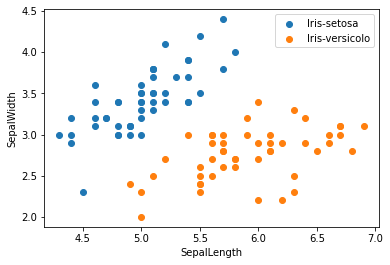

In [8]:
plt.scatter(iris[:50].SepalLengthCm, iris[:50].SepalWidthCm, label='Iris-setosa')
plt.scatter(iris[51:].SepalLengthCm, iris[51:].SepalWidthCm, label='Iris-versicolo')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')

#Define X and y

In [9]:
X = iris.drop(labels=['Id', 'Species'], axis=1).values
y = iris.Species.values
print("X shape: ", X.shape, "y shape: ", y.shape)
(m,n) = X.shape
print("Number of total examples: ", m, " Number of features: ", n)


X shape:  (100, 4) y shape:  (100,)
Number of total examples:  100  Number of features:  4


#Split data
- Train:test (70%:30%)
- Initializing the random seeds to regenerate the outputs

In [10]:
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)
train_index = np.random.choice(len(X), round(len(X) * 0.7), replace=False)

In [11]:
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

#Normalize
- Z normalization: feature_value-mean(feature)/standard_deviation(feature)
- Min/max normalization: feature_value - min(feature)/max(feature)-min(feature)


In [12]:
def z_normalization(feat_val):
  feat_mean = np.mean(feat_val, axis=0)
  feat_sd = np.std(feat_val, axis=0)
  return np.divide(feat_val - feat_mean, feat_sd)

In [13]:
# z normalize
X_train = z_normalization(X_train)
X_test = z_normalization(X_test)

#Weight and bias initialization

In [14]:
W = tf.Variable(tf.random.normal(shape=[n, 1]))
b = tf.Variable(tf.random.normal(shape=[1, 1]))
init = tf.global_variables_initializer()

#Defining the placeholders

In [15]:
data = tf.placeholder(dtype=tf.float32, shape=[None, n])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

#Model definition

In [16]:
mod = tf.matmul(data, W) + b

#Define loss function

In [17]:
#first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

#Initialize hyperparameters
- Batch size
- Learning rate
- Number of iterations

In [18]:
learning_rate = 0.01
batch_size = 20
iter_num = 500

#Define the optimizer

In [19]:
opt = tf.train.GradientDescentOptimizer(learning_rate)

#Define the goal
- minimize the defined loss

In [20]:
goal = opt.minimize(loss)

#Define accuracy

In [21]:
# The default threshold of sigmoid is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

# Initialize variables that analyze learning progress

In [22]:
loss_trace = []
train_acc = []
test_acc = []

#Training

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(iter_num):
  # Generate random batch index
  batch_index = np.random.choice(len(X_train), size=batch_size)
  batch_X_train = X_train[batch_index]
  batch_y_train = np.matrix(y_train[batch_index]).T
  sess.run(goal, feed_dict={data: batch_X_train, target: batch_y_train})
  temp_loss = sess.run(loss, feed_dict={data: batch_X_train, target: batch_y_train})
  temp_train_acc = sess.run(accuracy, feed_dict={data: X_train, target: np.matrix(y_train).T})
  temp_test_acc = sess.run(accuracy, feed_dict={data: X_test, target: np.matrix(y_test).T})
  loss_trace.append(temp_loss)
  train_acc.append(temp_train_acc)
  test_acc.append(temp_test_acc)
  if (epoch + 1) % 10 == 0:
    print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss, temp_train_acc, temp_test_acc))


epoch:   10 loss: 1.982295 train_acc: 0.342857 test_acc: 0.233333
epoch:   20 loss: 1.472155 train_acc: 0.357143 test_acc: 0.266667
epoch:   30 loss: 1.863117 train_acc: 0.385714 test_acc: 0.266667
epoch:   40 loss: 1.849467 train_acc: 0.400000 test_acc: 0.266667
epoch:   50 loss: 1.637010 train_acc: 0.442857 test_acc: 0.266667
epoch:   60 loss: 1.596818 train_acc: 0.471429 test_acc: 0.333333
epoch:   70 loss: 1.252428 train_acc: 0.500000 test_acc: 0.433333
epoch:   80 loss: 1.357625 train_acc: 0.557143 test_acc: 0.500000
epoch:   90 loss: 1.082574 train_acc: 0.571429 test_acc: 0.500000
epoch:  100 loss: 0.882788 train_acc: 0.585714 test_acc: 0.533333
epoch:  110 loss: 0.427756 train_acc: 0.628571 test_acc: 0.533333
epoch:  120 loss: 0.534466 train_acc: 0.628571 test_acc: 0.533333
epoch:  130 loss: 0.693133 train_acc: 0.685714 test_acc: 0.533333
epoch:  140 loss: 0.714973 train_acc: 0.742857 test_acc: 0.566667
epoch:  150 loss: 0.632976 train_acc: 0.785714 test_acc: 0.600000
epoch:  16

#Visualization of the loss function

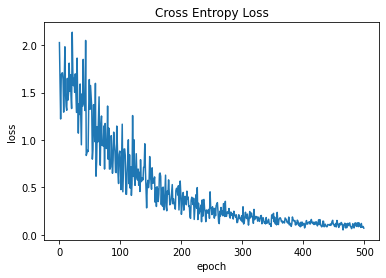

In [24]:

plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#Train and test accuracy visualization

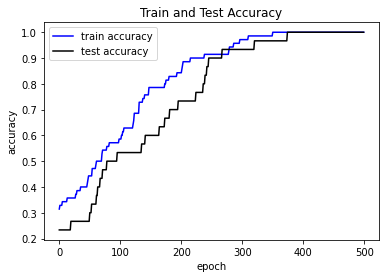

In [25]:

plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()